In [1]:
# Search
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']="https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY']=os.getenv("LANGCHAIN_API_KEY", None)
os.environ['LANGCHAIN_PROJECT']="agentic_rag_bam"

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY", None)

In [2]:
## LLM

import warnings
warnings.filterwarnings("ignore")

# from dotenv import load_dotenv
# load_dotenv(override=True)

from genai import Client, Credentials
from genai.extensions.langchain import LangChainInterface
from genai.schema import (
    DecodingMethod,
    TextGenerationParameters,
)
from langchain_ibm import WatsonxLLM, ChatWatsonx
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams


def bam_model(model_id='meta-llama/llama-3-8b-instruct', decoding_method='greedy', max_new_tokens=1000, 
              min_new_tokens=1, temperature=0.1, top_k=50, top_p=1, repetition_penalty=1):

    if decoding_method == 'greedy':
        decoding_method = DecodingMethod.GREEDY
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            repetition_penalty=repetition_penalty
        )
    else:
        decoding_method = DecodingMethod.SAMPLE
        parameters=TextGenerationParameters(
            decoding_method=decoding_method,
            max_new_tokens=max_new_tokens,
            min_new_tokens=min_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            repetition_penalty=repetition_penalty
        )

    llm = LangChainInterface(
        model_id=model_id,
        client=Client(credentials=Credentials.from_env()),
        parameters=parameters,
    )

    return llm

def watsonx_model(model_id="mistralai/mixtral-8x7b-instruct-v01", decoding_method='greedy', max_new_tokens=1000, 
                  min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):
    params = {
        GenParams.DECODING_METHOD: decoding_method,
        GenParams.MIN_NEW_TOKENS: min_new_tokens,
        GenParams.MAX_NEW_TOKENS: max_new_tokens,
        GenParams.RANDOM_SEED: 42,
        GenParams.TEMPERATURE: temperature,
        GenParams.TOP_K: top_k,
        GenParams.TOP_P: top_p,
        GenParams.REPETITION_PENALTY: repetition_penalty
    }
    ibm_cloud_url = os.getenv("IBM_CLOUD_URL", None)
    project_id = os.getenv("PROJECT_ID", None)
    api_key = os.getenv("API_KEY")
    watsonx_llm = ChatWatsonx(
        model_id=model_id,
        url=ibm_cloud_url,
        apikey=api_key,
        project_id=project_id,
        params=params,
    )
    return watsonx_llm
# prompt = "Tell me about IBM."
# print(f"Prompt: {prompt}")

# local_llm = bam_model()
local_llm = watsonx_model()
# print(local_llm.invoke(prompt))


# local_llm = "llama3"
# model_tested = "meta-llama/llama-3-8b-instruct"
# metadata = f"Agentic-RAG, {model_tested}"

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")


In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
## Prompts

PLAN_PROMPT = """[INST]
You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections. 
[/INST]"""



WRITER_PROMPT = """[INST]
You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}

[/INST]"""



REFLECTION_PROMPT = """[INST]
You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc.
[/INST]"""


RESEARCH_PLAN_PROMPT = """[INST]
You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max.
[/INST]"""



RESEARCH_CRITIQUE_PROMPT = """[INST]
You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.
[/INST]"""


In [6]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [7]:
from tavily import TavilyClient
tavily = TavilyClient()

In [8]:
model = local_llm

In [9]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [10]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [11]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
            SystemMessage(
                content=WRITER_PROMPT.format(content=content)
            ),
            user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [12]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [13]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [14]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

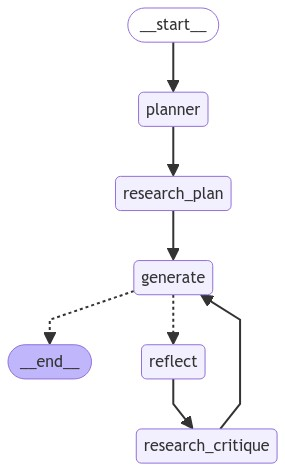

In [15]:
builder = StateGraph(AgentState)

builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

builder.set_entry_point("planner")

builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {
        END: END, 
        "reflect": "reflect"
    }
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
from pprint import pprint

thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
        'task': "what is the difference between langchain and langsmith",
        "max_revisions": 2,
        "revision_number": 1,
    }, thread):
    pprint(s, indent=2, width=80, depth=None)

{ 'planner': { 'plan': '\n'
                       '\n'
                       'Title: Comparative Analysis of Langchain and '
                       'Langsmith: Understanding the Differences\n'
                       '\n'
                       'I. Introduction\n'
                       'A. Brief overview of Langchain and Langsmith\n'
                       'B. Importance of understanding the differences\n'
                       'C. Purpose of the essay\n'
                       '\n'
                       'II. Langchain: A Comprehensive Overview\n'
                       'A. History and development\n'
                       'B. Key features and functionalities\n'
                       'C. Strengths and limitations\n'
                       'D. User reviews and feedback\n'
                       '\n'
                       'III. Langsmith: A Comprehensive Overview\n'
                       'A. History and development\n'
                       'B. Key features and functionalities\n'


In [19]:
print(s['generate']['draft'])



Title: Comparative Analysis of Langchain and Langsmith: Understanding the Differences

I. Introduction
A. Langchain is a versatile open-source framework that enables you to build applications utilizing large language models (LLM) like GPT-3. Langsmith, on the other hand, acts as an AI compass built into LangChain, guiding users through the intricate decision-making processes of LLMs.
B. Understanding the differences between Langchain and Langsmith is crucial for developers and researchers looking to build applications utilizing LLMs.
C. This essay aims to provide a comprehensive overview of both systems and a detailed comparative analysis.

II. Langchain: A Comprehensive Overview
A. Langchain was originally created to reduce the barrier to entry for building prototypes with LLMs. It is a versatile open-source framework that supports various programming languages.
B. Langchain enables users to build applications utilizing LLMs like GPT-3, and it is known for its heavy lifting capabili

## Essay Writer Interface

In [20]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [21]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Failure during generate. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/generation?version=2024-07-29)
Status code: 500, body: {"errors":[{"code":"fmaas_downstream_request_failed","message":"Downstream FMAAS request with 'mistralai/mixtral-8x7b-instruct-v01' failed: transport error","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai"}],"trace":"76dbe4801b479ec46ecc3a6c5941b9a5","status_code":500}
Traceback (most recent call last):
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/gradio/route_utils.py", line 285, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sourav/workstuffs/env_exp/lib/python3.11/site-packages/gradio/blocks.py", line 1923, in process_api
